# Лабораторная работа 5. Классификация изображений с помощью сверточной нейронной сети

### Работу выполнил:<span style="color:blue"> {ваше имя и фамилия}</span>

### Сделанную лабораторную работу отправляйте через [ФОРМУ](https://vyatsu-my.sharepoint.com/:f:/g/personal/usr09019_vyatsu_ru/Ei2kQNkh2ABHuYFR4BPtyrEBRGDgM28MZCQVhyrDQOEOGA)

## Задание 1.

Построить сверточную нейронную сеть для классификации изображений на основе датасета Intel Image Classification (https://www.kaggle.com/datasets/puneet6060/intel-image-classification). Задание предполагает самостоятельное создание структуры сети и обучение её с нуля.

В работе можно ориентироваться на структуру сети [AlexNet](https://en.wikipedia.org/wiki/AlexNet).

Ниже приводится пример создания сети с использованием библиотеки PyTorch. Данный пример не является готовым решением: сеть переобучилась и на тестовых данных показывает низкое значение метрик качества (accuracy/loss).

Задание считается выполненным при достижении accuracy=0.83 на тестовом наборе данных.

In [2]:
# Импортируем необходимые модули
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [3]:
# Директории обучающих и тестовых данных
data_dir = "../data/seg_train/seg_train"
test_data_dir = "../data/seg_test/seg_test"

In [4]:
# Улучшенные преобразования с аугментацией для обучающих данных
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(p=0.5),  # Случайное отражение по горизонтали
    transforms.RandomRotation(degrees=15),   # Случайный поворот на ±15 градусов
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Изменение цветовых характеристик
    transforms.ToTensor(),
])

# Преобразования для валидационных и тестовых данных (без аугментации)
val_test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

# Загружаем данные с разными преобразованиями
dataset = ImageFolder(data_dir, transform=train_transform)
test_dataset = ImageFolder(test_data_dir, transform=val_test_transform)

In [5]:
# Посмотрим на размерность данных и метки
img, label = dataset[0]
print(img.shape, label)

torch.Size([3, 150, 150]) 0


In [6]:
print("Классы изображений : \n", dataset.classes)

Классы изображений : 
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Label : buildings


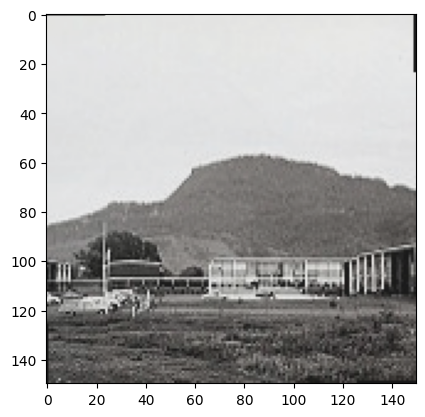

In [7]:
# Определим функцию для отображения изображений датасета
def display_img(img, label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))  # Преобразуем (3, 150, 150) в (150, 150, 3)

# Отобразим первое изображение датасета
display_img(*dataset[0])

In [8]:
# Определяем структуру нейронной сети с Batch Normalization и Dropout
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self, numChannels, classes):
        # Вызываем родительский конструктор
        super(ConvNet, self).__init__()

        # Первый набор слоев CONV => BN => RELU => POOL
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=32, kernel_size=(3, 3), padding=(1, 1))
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # Второй набор слоев CONV => BN => RELU => POOL
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # Третий набор слоев CONV => BN => RELU => POOL
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # Первый набор слоев FC => BN => RELU => DROPOUT
        self.fc1 = nn.Linear(in_features=41472, out_features=1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)  # Более высокий dropout для полносвязных слоев

        # Второй набор слоев FC => BN => RELU => DROPOUT
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu5 = nn.ReLU()

        # Инициализируем классификатор softmax
        self.fc3 = nn.Linear(in_features=512, out_features=classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Первый блок: CONV => BN => RELU => POOL => DROPOUT
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # Второй блок: CONV => BN => RELU => POOL => DROPOUT
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # Третий блок: CONV => BN => RELU => POOL => DROPOUT
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        # Переводим результат предыдущего слоя в одномерный вид
        x = torch.flatten(x, 1)

        # Полносвязные слои с BatchNorm и Dropout
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.dropout4(x)

        x = self.fc2(x)
        x = self.bn5(x)
        x = self.relu5(x)

        # Классификатор (без dropout)
        x = self.fc3(x)
        output = self.logSoftmax(x)

        return output

In [9]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

# Определяем гиперпараметры
BATCH_SIZE = 32
INIT_LR = 1e-3
EPOCHS = 15
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

train_size = int(len(dataset) * TRAIN_SPLIT)
val_size = len(dataset) - train_size

# Определяем устройство, которое будет использоваться для обучения модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data, val_data = random_split(dataset, [train_size, val_size])

print(f"Размер обучающих данных: {len(train_data)}")
print(f"Размер валидационных данных : {len(val_data)}")

# Загружаем обучающие, валидационные и тестовые данные в батчи
train_dl = DataLoader(train_data, BATCH_SIZE, shuffle=True, num_workers=0)
val_dl = DataLoader(val_data, BATCH_SIZE, num_workers=0)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Вычисляем количество шагов на одну эпоху для обучающего и валидационного набора
train_steps = len(train_dl.dataset) // BATCH_SIZE
val_steps = len(val_dl.dataset) // BATCH_SIZE

Размер обучающих данных: 10525
Размер валидационных данных : 3509


In [10]:
from torch.optim import Adam
import time

# Инициализируем модель нейронной сети
model = ConvNet(
	numChannels=3,
	classes=len(dataset.classes)).to(device)
# Инициализируем оптимизатор и функцию потерь
opt = Adam(model.parameters(), lr=INIT_LR, weight_decay=1e-4)
loss_fn = nn.NLLLoss()
# Инициализируем словарь для сохранения истории обучения
H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}

In [11]:
# Будем замерять, как долго длился процесс обучения
start_time = time.time()

# Цикл по эпохам
for e in range(0, EPOCHS):
	# Переводим модель в режим обучения
	model.train()
	# Переменные для хранения общих потерь обучения и валидации
	total_train_loss = 0
	total_val_loss = 0
	# Количество корректных предсказаний на шаге обучения
	# и валидации
	train_сorrect = 0
	val_сorrect = 0
	# Цикл по обучающему множеству
	for (x, y) in train_dl:
		# Посылаем данные на устройство
		(x, y) = (x.to(device), y.to(device))
		# Выполняем прямой проход и считаем потери при обучении
		pred = model(x)
		loss = loss_fn(pred, y)
		# Обнуляем градиенты, выполняем шаг обратного распространения ошибки,
		# и обновляем веса
		opt.zero_grad()
		loss.backward()
		opt.step()
		# Добавляем потери к общим потерям и
		# вычисляем количество правильных предсказаний
		total_train_loss += loss
		train_сorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()

	# Отключаем автоградиент для определения качества
	with torch.no_grad():
		# Переводим модель в режим определения качества
		model.eval()
		# Цикл по валидационному множеству
		for (x, y) in val_dl:
			# Посылаем данные на устройство
			(x, y) = (x.to(device), y.to(device))
			# Выполняем предсказания и находим потери при валидации
			pred = model(x)
			total_val_loss += loss_fn(pred, y)
			# Вычисляем количество правильных предсказаний
			val_сorrect += (pred.argmax(1) == y).type(
				torch.float).sum().item()

	# Вычисляем средние потери при обучении и валидации
	avg_train_loss = total_train_loss / train_steps
	avg_val_loss = total_val_loss / val_steps
	# Вычисляем accuracy при обучении и валидации
	train_сorrect = train_сorrect / len(train_dl.dataset)
	val_сorrect = val_сorrect / len(val_dl.dataset)
	# Обновляем историю обучения
	H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
	H["train_acc"].append(train_сorrect)
	H["val_loss"].append(avg_val_loss.cpu().detach().numpy())
	H["val_acc"].append(val_сorrect)
	# Выводим информации оо обучении и валидации модели
	print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
		avg_train_loss, train_сorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
		avg_val_loss, val_сorrect))

end_time = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	end_time - start_time))

[INFO] EPOCH: 1/15
Train loss: 0.845066, Train accuracy: 0.6848
Val loss: 0.681061, Val accuracy: 0.7486

[INFO] EPOCH: 2/15
Train loss: 0.660583, Train accuracy: 0.7580
Val loss: 0.783731, Val accuracy: 0.7030

[INFO] EPOCH: 3/15
Train loss: 0.611929, Train accuracy: 0.7709
Val loss: 0.673416, Val accuracy: 0.7640

[INFO] EPOCH: 4/15
Train loss: 0.580146, Train accuracy: 0.7906
Val loss: 0.634874, Val accuracy: 0.7669

[INFO] EPOCH: 5/15
Train loss: 0.539916, Train accuracy: 0.8049
Val loss: 0.977575, Val accuracy: 0.6600

[INFO] EPOCH: 6/15
Train loss: 0.529268, Train accuracy: 0.8055
Val loss: 0.587446, Val accuracy: 0.7828

[INFO] EPOCH: 7/15
Train loss: 0.516527, Train accuracy: 0.8135
Val loss: 0.652832, Val accuracy: 0.7563

[INFO] EPOCH: 8/15
Train loss: 0.505005, Train accuracy: 0.8162
Val loss: 0.576044, Val accuracy: 0.7897

[INFO] EPOCH: 9/15
Train loss: 0.483052, Train accuracy: 0.8228
Val loss: 0.646051, Val accuracy: 0.7760

[INFO] EPOCH: 10/15
Train loss: 0.488035, Trai

In [12]:
# Сейчас мы можем оценить качество модели на тестовом наборе данных
from sklearn.metrics import classification_report
import numpy as np

# Отключаем автоградиент для определения качества
with torch.no_grad():
	# Переводим модель в режим определения качества
	model.eval()

	# Список для хранения предсказаний
	preds = []
	# Цикл по тестовому набору данных
	for (x, y) in test_dl:
		# Посылаем данные на устройство
		x = x.to(device)
		# Делаем предсказание и помещаем в список
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
# Генерируем отчёт о классификации
print(classification_report(test_dataset.targets, np.array(preds), target_names=test_dataset.classes))

              precision    recall  f1-score   support

   buildings       0.77      0.87      0.82       437
      forest       0.95      0.96      0.96       474
     glacier       0.74      0.88      0.81       553
    mountain       0.77      0.79      0.78       525
         sea       0.92      0.75      0.82       510
      street       0.92      0.77      0.83       501

    accuracy                           0.83      3000
   macro avg       0.85      0.84      0.84      3000
weighted avg       0.84      0.83      0.84      3000



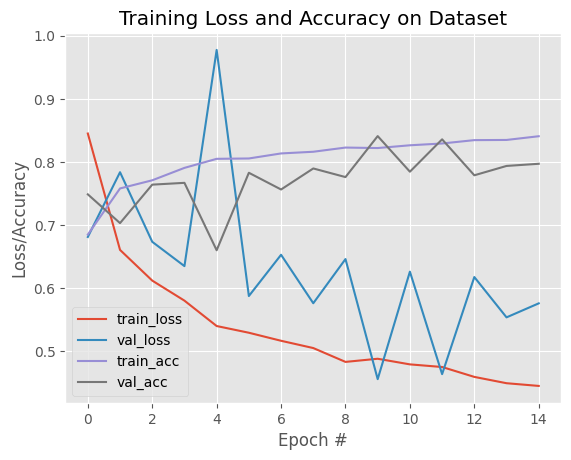

In [13]:
# График потерь и accuracy при обучении
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# Сохраняем модель на диск
torch.save(model, "cnn.pt")

## Задание 2.

Написать функцию, выполняющую предсказание класса для входного изображения. На вход функция принимает имя файла, а возвращает предсказанный класс.

In [26]:
import torch
def predict_image_class(model_path, image_path, class_names):

    model = torch.load(model_path, weights_only=False)
    model.eval()
    model.to(device)

    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor()
    ])

    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    with torch.no_grad():
        output = model(image)
        predicted_class = torch.argmax(output, 1).item()

    return class_names[predicted_class]

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
predicted_class = predict_image_class("cnn.pt", "img.jpg", class_names)
print(f"Предсказанный класс: {predicted_class}")

Предсказанный класс: mountain


## Задание 3.

Выполнить задание 2, используя предобученную сеть AlexNet, доступную в PyTorch ([ссылка](https://pytorch.org/hub/pytorch_vision_alexnet/)). Выполнять дообучение сети не нужно.

In [27]:

from torchvision import models, transforms
from PIL import Image

def predict_image_class_alexnet(image_path):
    model = models.alexnet(pretrained=True)
    model.eval()

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted_class = predicted.item()


    import requests
    labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    labels = requests.get(labels_url).text.split('\n')

    return labels[predicted_class]

predicted_class = predict_image_class_alexnet("img.jpg")
print(f"Предсказанный класс: {predicted_class}")

C:\Users\giezz\PycharmProjects\computer-vision\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\giezz\PycharmProjects\computer-vision\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Предсказанный класс: promontory
